In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time
import torch
import torchvision
import cv2
from PIL import Image
import os

In [2]:
import pandas as pd

In [3]:
from torchvision import datasets, transforms

In [4]:
import zipfile

In [7]:
with zipfile.ZipFile('c:/users/srini/Desktop/FaceMaskProject/custom_dataset.zip','r') as zip_ref:
  zip_ref.extractall('/content/Mask Detection')

In [8]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

In [9]:
transform = transforms.Compose([
                  transforms.RandomResizedCrop(size=256),
                  transforms.RandomRotation(degrees=15),
                  transforms.RandomHorizontalFlip(),
                  transforms.ToTensor(),
                  transforms.Normalize(mean, std)
])

In [10]:
from torch.utils.data import DataLoader,Dataset

#Creating Custom Dataset

In [11]:
class CustomDataset(Dataset):

  def __init__(self,csv_file, root_dir, transform=None):
    self.annotations = pd.read_csv(csv_file)
    self.root_dir = root_dir
    self.transform = transform

  def __len__(self):
    return len(self.annotations)

  def __getitem__(self, index):
    y_label = torch.tensor(int(self.annotations.iloc[index,-1]))
    img_path = os.path.join(self.root_dir, self.annotations.iloc[index,1])
    image = Image.open(img_path)
    

    if self.transform:
      image = self.transform(image)

    return (image, y_label)


In [12]:
dataset = CustomDataset('/content/Mask Detection/my_file/csv_file.csv', '/content/Mask Detection/my_file/Combined', transform=transform)

In [13]:
# Ensuring the train and test sizes as 80% & 20% respectively

train_size = int(0.8 * 1376)
test_size = 1376 - train_size

In [14]:
trainset, testset = torch.utils.data.random_split(dataset, [train_size, test_size]) # Splitting the dataset into train & test

In [15]:
trainloader = DataLoader(trainset, batch_size=16, shuffle=True)  # Creating dataloader for training

In [16]:
# Checking the trainloader contents

images, labels = iter(trainloader).next()
print(images.shape)
print(labels.shape)
print(labels)

torch.Size([16, 3, 256, 256])
torch.Size([16])
tensor([1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1])


In [17]:
testloader = DataLoader(testset, batch_size=16, shuffle=True)   # Creating the dataloader for testing

In [18]:
from torch import optim
import torch.nn as nn

In [19]:
from torchvision import models

In [20]:
# Using Pretrained Resnet18 architechture with a custom layer

def create_model(n_classes):
  model = models.resnet18(pretrained=True)

  n_features = model.fc.in_features

  model.fc = nn.Sequential(
      nn.Linear(n_features, n_classes),
      nn.Softmax(dim=1)
  )

  return model

In [35]:
# Instantiation
base_model = create_model(2) 

#Evaluation

In [36]:
def evaluation(dataloader):
    total, correct = 0, 0
    for data in dataloader:
        inputs, labels = data
        outputs = base_model(inputs)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
    return 100 * correct / total

In [37]:
# Defining Optimizer and Loss Function
opt = optim.SGD(base_model.parameters(),lr=0.001,momentum=0.9)
loss_fn = nn.CrossEntropyLoss()

#Training

Epoch: 0/4, Test acc: 94.57, Train acc: 92.64
Epoch: 1/4, Test acc: 94.57, Train acc: 94.09
Epoch: 2/4, Test acc: 93.84, Train acc: 93.73
Epoch: 3/4, Test acc: 94.57, Train acc: 93.36


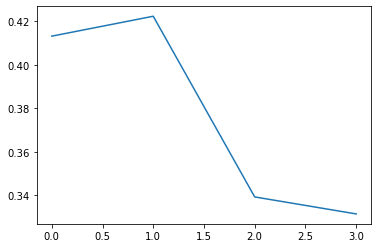

Wall time: 14min 13s


In [24]:
%%time
loss_arr = []
loss_epoch_arr = []
max_epochs = 4
     
for epoch in range(max_epochs):
     
  for i, data in enumerate(trainloader, 0):
     
    inputs, labels = data

    opt.zero_grad()
     
    outputs = base_model(inputs)
    loss = loss_fn(outputs, labels)
    loss.backward()
    opt.step()  
         
    loss_arr.append(loss.item())
        
  loss_epoch_arr.append(loss.item())
         
  print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (epoch, max_epochs, evaluation(testloader), evaluation(trainloader)))

plt.plot(loss_epoch_arr)
plt.show()

#Saving and Loading

In [38]:
torch.save(base_model.state_dict(), 'C:/Users/srini/Desktop/FaceMaskProject/model.pth')

In [39]:
model = base_model(2)
model.load_state_dict(torch.load('C:/Users/srini/Desktop/FaceMaskProject/model.pth'))
model.eval()

TypeError: conv2d(): argument 'input' (position 1) must be Tensor, not int